In [1]:
import sys
sys.path.append('../source')
import get_data, compute_comethylation

import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from scipy import stats

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig_out_dir = "../figures/figure4"
dependency_f_dir = "../dependency_files"


/tmp/ipykernel_4054818/2052993543.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


# Read ICGC data

In [2]:
# read in illumina cpg locations
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))

# read in icgc metadata
icgc_data_dir = "../data/icgc"
meta_fn = os.path.join(icgc_data_dir, "icgc_meta.csv")
icgc_metadata, dsest_names = get_data.get_metadata(meta_fn, is_icgc=True)

# read in mutation and methylation data (quantile normalized)
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [3]:
# read in methylation disturbance of icgc samples, upto 1Mb from each mutaiton
icgc_dist_mean_metrics_df = pd.read_parquet('../data/methylation_disturbance/icgc_dist_mean_metrics_1mb.parquet')
# same mean disturbance across 10kb and with annotations of genomic context, filted to for DNAVAF >=.8
icgc_dist_mean_metrics_w_annot_df_subset_vaf = pd.read_parquet('../data/methylation_disturbance/icgc_dist_mean_metrics10kDist_w_annot_subset_vaf.parquet')

# same mean disturbance across 10kb and with annotations of genomic context, but for mutations with any vaf
icgc_dist_mean_metrics_w_annot_all_vaf = pd.read_parquet('../data/methylation_disturbance/icgc_dist_mean_metrics10kDist_w_annot_all_vaf.parquet')

# create analyzeComethylation object
analyze_comethylation = compute_comethylation.analyzeComethylation()

# Figure 4a

In [9]:
icgc_dist_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_dist_mean_metrics_df, distance = -1, consortium = 'ICGC')
selected_mut_events = icgc_dist_mean_metrics_w_annot_df.query("mutated_sample == True and is_background == False and DNA_VAF >=.8")['mut_event'].unique()
icgc_dist_mean_metrics_w_annot_df_subset = icgc_dist_mean_metrics_w_annot_df.loc[
    (icgc_dist_mean_metrics_w_annot_df['index_event'].isin(selected_mut_events) | (icgc_dist_mean_metrics_w_annot_df['index_event'] == 'self') & (icgc_dist_mean_metrics_w_annot_df['is_background'] == False) & (icgc_dist_mean_metrics_w_annot_df['DNA_VAF'] >=.8))
].copy(deep = True)
#icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

icgc_dist_mean_metrics_w_annot_df_subset['total_abs_dmf'] = icgc_dist_mean_metrics_w_annot_df_subset['median_abs_dmf'] * icgc_dist_mean_metrics_w_annot_df_subset['num_measured_sites']
icgc_dist_mean_metrics_w_annot_df_subset['total_dmf'] = icgc_dist_mean_metrics_w_annot_df_subset['median_dmf'] * icgc_dist_mean_metrics_w_annot_df_subset['num_measured_sites']

1
Ttest_indResult(statistic=3.4082483286592073, pvalue=0.0006549665300876164)
10
Ttest_indResult(statistic=3.363666534660047, pvalue=0.0007704346087179828)
100
Ttest_indResult(statistic=3.6320554055029897, pvalue=0.00028179445049921235)
10000
Ttest_indResult(statistic=3.364011629553711, pvalue=0.0007693287746863127)
1000
Ttest_indResult(statistic=4.076621780115252, pvalue=4.584345705246521e-05)
5000
Ttest_indResult(statistic=2.888537766117754, pvalue=0.0038736790689852564)
50000
Ttest_indResult(statistic=2.2396128343084487, pvalue=0.025124665479746542)
990000
Ttest_indResult(statistic=0.6342998427532868, pvalue=0.5258913744378677)
100000
Ttest_indResult(statistic=1.9232585250355634, pvalue=0.05445874149409493)
500000
Ttest_indResult(statistic=0.7651312045141598, pvalue=0.4442007225222885)


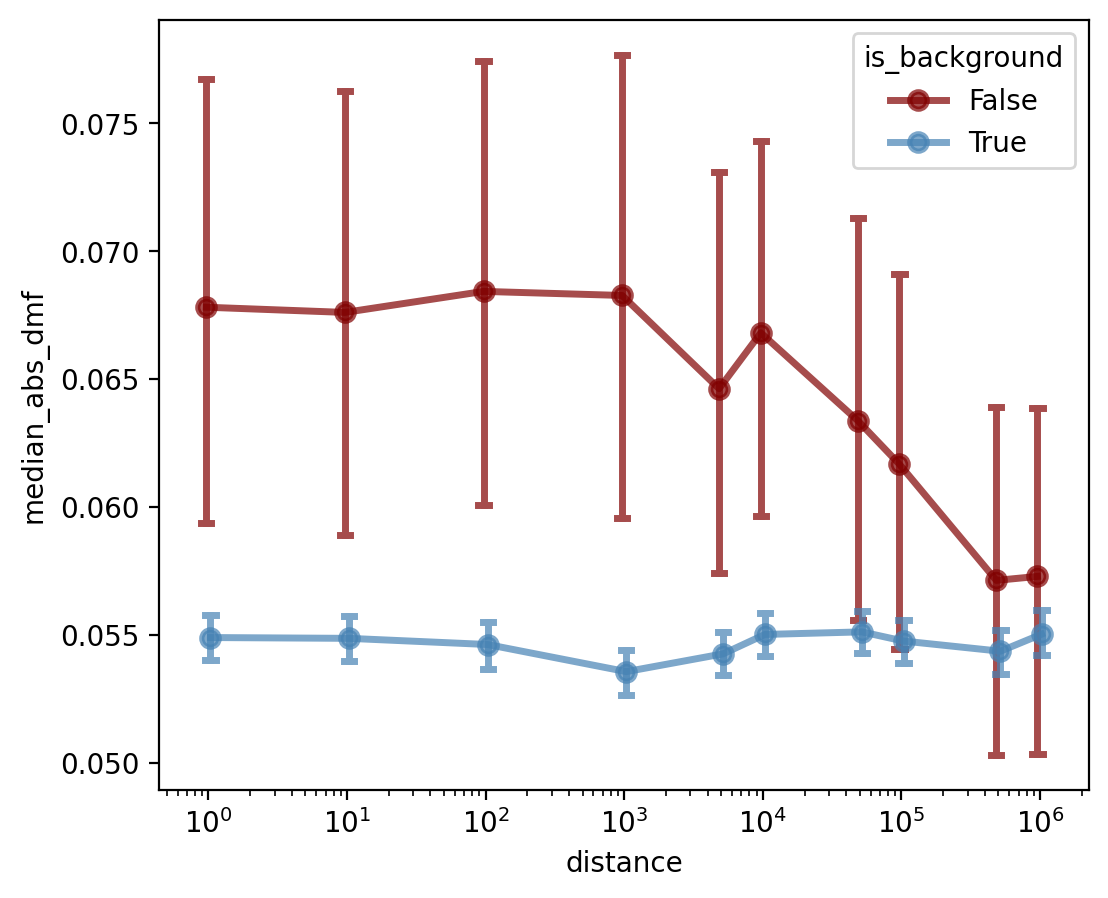

In [10]:
# 1000 bp 
fig, axes = plt.subplots(1, 1, figsize = (6, 5))
# convert to log scale
sns.pointplot(
    icgc_dist_mean_metrics_w_annot_df_subset,
    x = 'distance', hue = 'is_background', y = 'median_abs_dmf', ax = axes,
    native_scale=True, palette=['maroon', 'steelblue'], dodge=.1,
    capsize = .25, alpha=.7, log_scale=(True, False), linewidth = 2.5,
    estimator=np.mean, errorbar = 'ci',
)
for distance in icgc_dist_mean_metrics_w_annot_df_subset['distance'].unique():
    print(distance)
    # get the two groups
    group1 = icgc_dist_mean_metrics_w_annot_df_subset.query("distance == @distance and is_background == False")['median_abs_dmf']
    group2 = icgc_dist_mean_metrics_w_annot_df_subset.query("distance == @distance and is_background == True")['median_abs_dmf']
    from scipy.stats import ttest_ind
    print(ttest_ind(group1, group2))
    
plt.savefig(os.path.join(fig_out_dir, "figure4a.svg"), dpi = 300, bbox_inches = 'tight', format = 'svg')

# Figure 4b-c

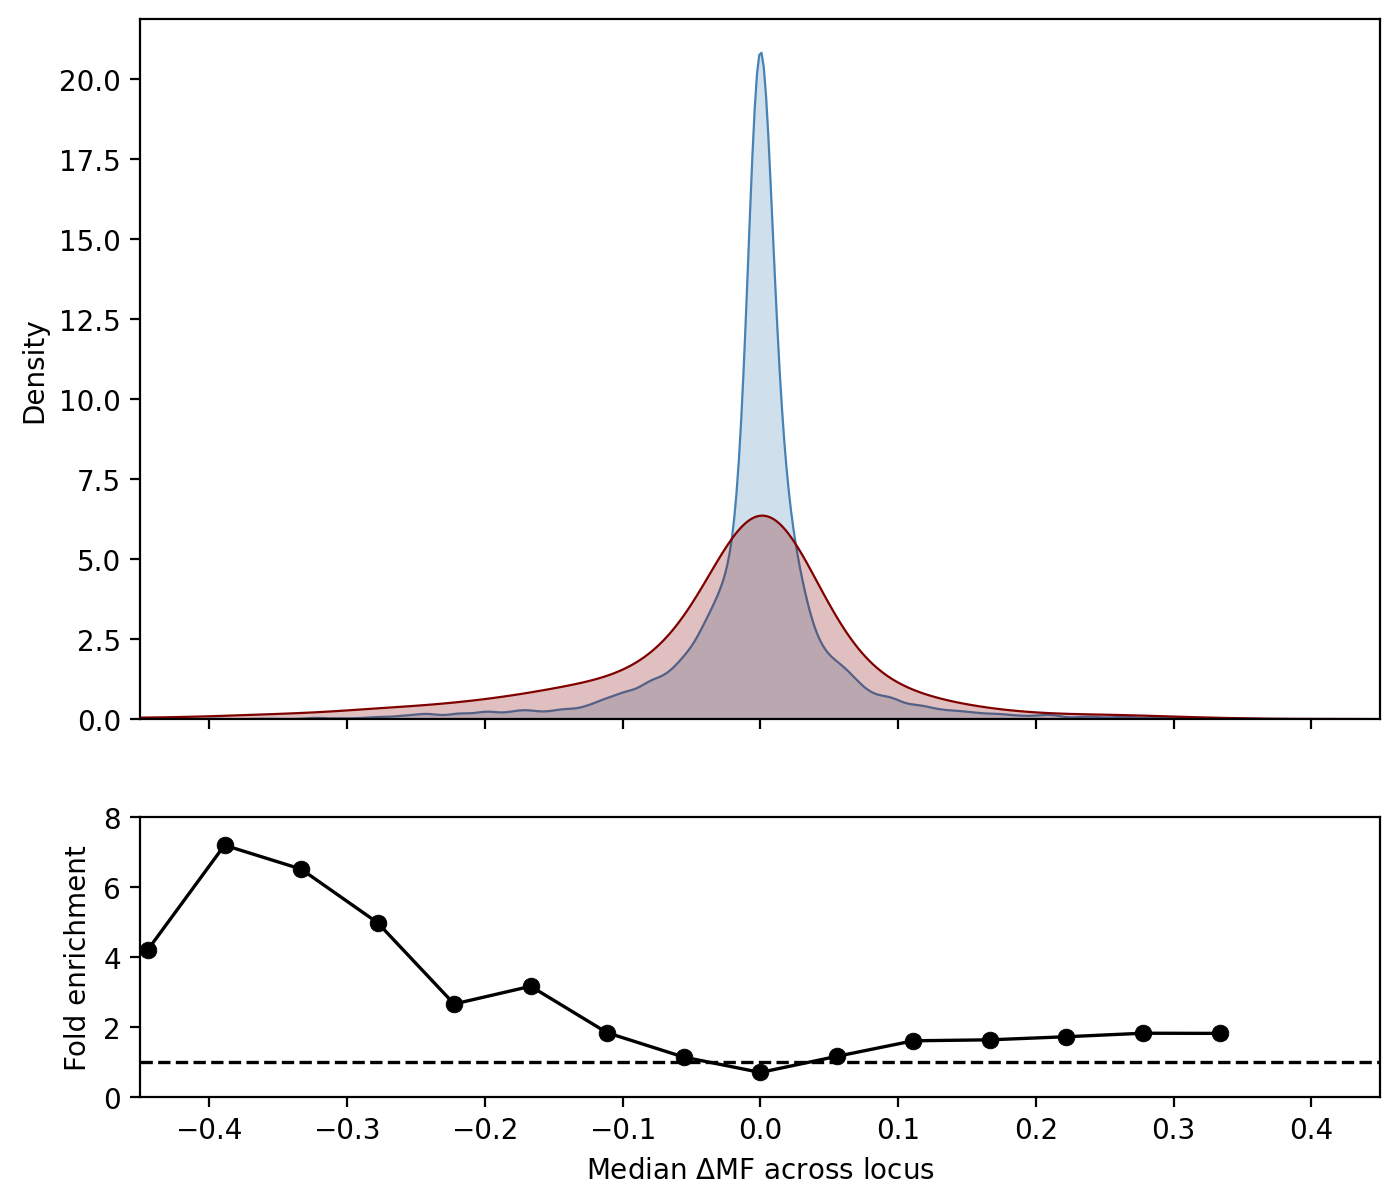

In [6]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_dist_mean_metrics_w_annot_df_subset_vaf,
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn = os.path.join(fig_out_dir, 'figure4b-c.svg')
    ) 

# Figure 4d

In [7]:
filtered_df = icgc_dist_mean_metrics_w_annot_df_subset_vaf.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )

In [8]:
cgi_df = pd.read_csv('../dependency_files/CpG_islands_hg19.bed.gz', sep = '\t', header = None)
cgi_df.columns = ['chr', 'start', 'end', 'name']
cgi_df['length'] = cgi_df['end'] - cgi_df['start']
print("total number of bp in CGI: ", cgi_df['length'].sum())
print("percentage of genome in CGI: ", cgi_df['length'].sum() / 3137144693)
percent_genome_that_is_cgi = cgi_df['length'].sum() / 3137144693

# get background frequency values for CpG outside CGI, CpG inside CGI, non-CpG outside CGI, non-CpG inside CGI
genome_length = 3137144693 # UCSC
percent_genome_that_is_cgi = 0.00737030269964663 # derived from UCSC CGI file
percent_cpgs_in_cgi = 0.07 # youk et al
percent_cpgs_not_in_cgi = 0.93 # youk et al
num_cpgs = 28299634 # UCSC
bp_in_cpg = 28299634 * 2 # UCSC
basepairs_in_cgi = 23121706 # derived from UCSC CGI file
basepairs_not_in_cgi = 3137144693 - 23121706


percent_cgi_that_is_cpg = (bp_in_cpg * percent_cpgs_in_cgi)/(basepairs_in_cgi)# the percent of CG
percent_non_cgi_that_is_cpg = (bp_in_cpg * percent_cpgs_not_in_cgi)/(basepairs_not_in_cgi)

percent_cpg_not_cgi = percent_non_cgi_that_is_cpg * (1 - percent_genome_that_is_cgi)
percent_cpg_and_cgi = percent_cgi_that_is_cpg * percent_genome_that_is_cgi

percent_non_cpg_not_cgi = (1 - percent_non_cgi_that_is_cpg) * (1 - percent_genome_that_is_cgi)
percent_non_cpg_and_cgi = (1 - percent_cgi_that_is_cpg) * percent_genome_that_is_cgi

filtered_df = icgc_dist_mean_metrics_w_annot_df_subset_vaf.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 1000 events, which is about 25%
num_top_muts = 1000 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
# create a new df to plot
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
y_proportions = {
    "CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == True").shape[0] / top_df.shape[0], 
        bottom_df.query("is_cgi == False and was_cpg == True").shape[0] / bottom_df.shape[0]
        ]),
    "CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == True").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == True and was_cpg == True").shape[0] / bottom_df.shape[0]
        ]),
    "non-CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == False").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == False and was_cpg == False").shape[0] / bottom_df.shape[0]
        ]),
    "non-CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == False").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == True and was_cpg == False").shape[0] / bottom_df.shape[0]
        ]),
}
y_counts = {
    "CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == True").shape[0], 
        bottom_df.query("is_cgi == False and was_cpg == True").shape[0]
        ]),
    "CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == True").shape[0],
        bottom_df.query("is_cgi == True and was_cpg == True").shape[0]
        ]),
    "non-CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == False").shape[0],
        bottom_df.query("is_cgi == False and was_cpg == False").shape[0]
        ]),
    "non-CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == False").shape[0],
        bottom_df.query("is_cgi == True and was_cpg == False").shape[0]
        ]),
}


enrichments = {}
enrichments['CpG outside CGI'] = y_proportions['CpG outside CGI'] / percent_cpg_not_cgi
enrichments['CpG in CGI'] = y_proportions['CpG in CGI'] / percent_cpg_and_cgi
enrichments['non-CpG outside CGI'] = y_proportions['non-CpG outside CGI'] / percent_non_cpg_not_cgi
enrichments['non-CpG in CGI'] = y_proportions['non-CpG in CGI'] / percent_non_cpg_and_cgi
# create df
enrichments_df = pd.DataFrame(enrichments)
# stack
enrichments_df = enrichments_df.stack().reset_index()
# rename
enrichments_df.columns = ['Methylation change direction', 'Functional region', 'Fold-enrichment']
# map Methylation change direction 0 to Gain and 1 to Loss
enrichments_df['Methylation change direction'] = enrichments_df['Methylation change direction'].map({0: 'Gain', 1: 'Loss'})

total number of bp in CGI:  23121706
percentage of genome in CGI:  0.00737030269964663


/tmp/ipykernel_83724/2022261032.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_83724/2022261032.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


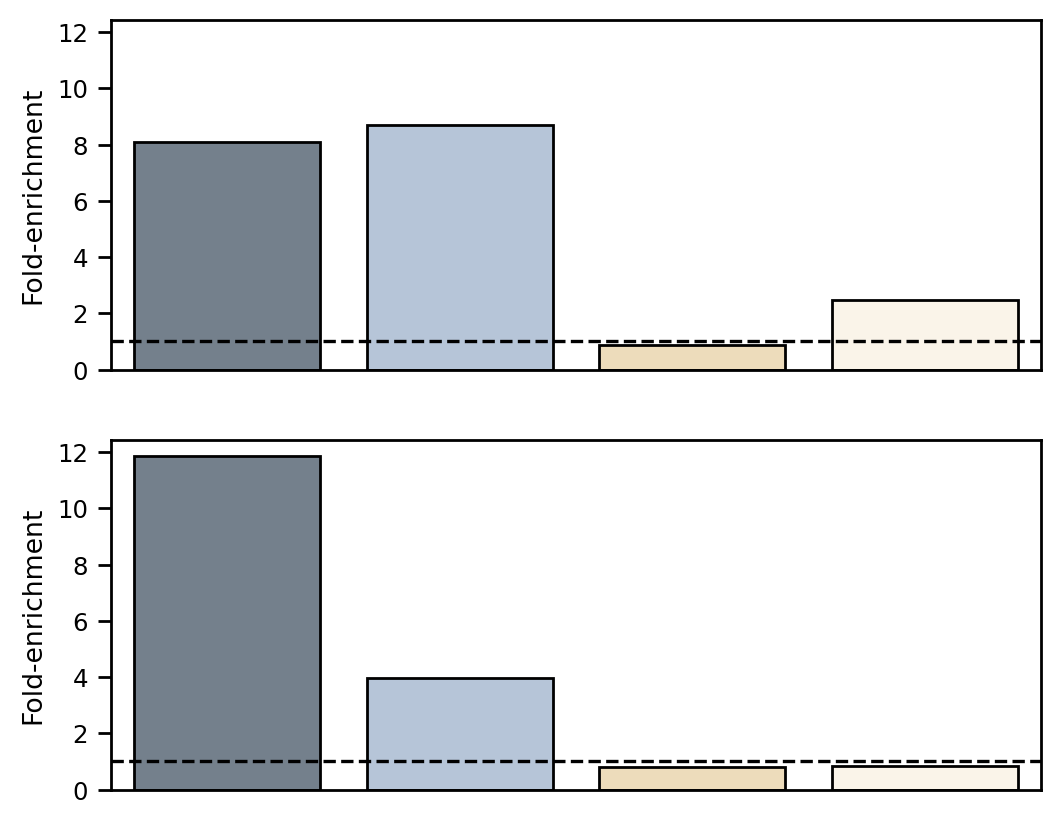

In [9]:
# plot enrichments as barplot
fig, axes = plt.subplots(2, 1, figsize=(6, 5), dpi = 100, sharex='col', sharey='col')
sns.set_context('paper')
sns.barplot(
    data=enrichments_df[enrichments_df['Methylation change direction'] == 'Gain'], y='Fold-enrichment', x='Functional region',
    #hue_order = [ 'CpG in CGI', 'non-CpG in CGI','CpG outside CGI', 'non-CpG outside CGI', ],
    palette=['slategray', 'lightsteelblue', 'wheat', 'oldlace'],
    edgecolor='black', linewidth=1,
    ax=axes[0]
)
axes[0].set_xlabel('')
sns.barplot(
    data=enrichments_df[enrichments_df['Methylation change direction'] == 'Loss'], y='Fold-enrichment', x='Functional region',
    #hue_order = [ 'CpG in CGI', 'non-CpG in CGI','CpG outside CGI', 'non-CpG outside CGI', ],
    palette=['slategray', 'lightsteelblue', 'wheat', 'oldlace'],
    edgecolor='black', linewidth=1,
    ax=axes[1]
)
axes[1].set_xlabel('')
# turn off legend
axes[0].legend().set_visible(False)
# plot dashed line at y = 1
axes[0].axhline(1, ls='--', color='black')
axes[1].axhline(1, ls='--', color='black')
# remove x ticks and labels
axes[0].set_xticklabels([])
axes[1].set_xticks([])
# remove y axes labels
# set super y axis label
plt.savefig(os.path.join(fig_out_dir, 'figure4d.svg'), dpi = 300, format = 'svg')

# Figure 4e

/tmp/ipykernel_83724/1384784986.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


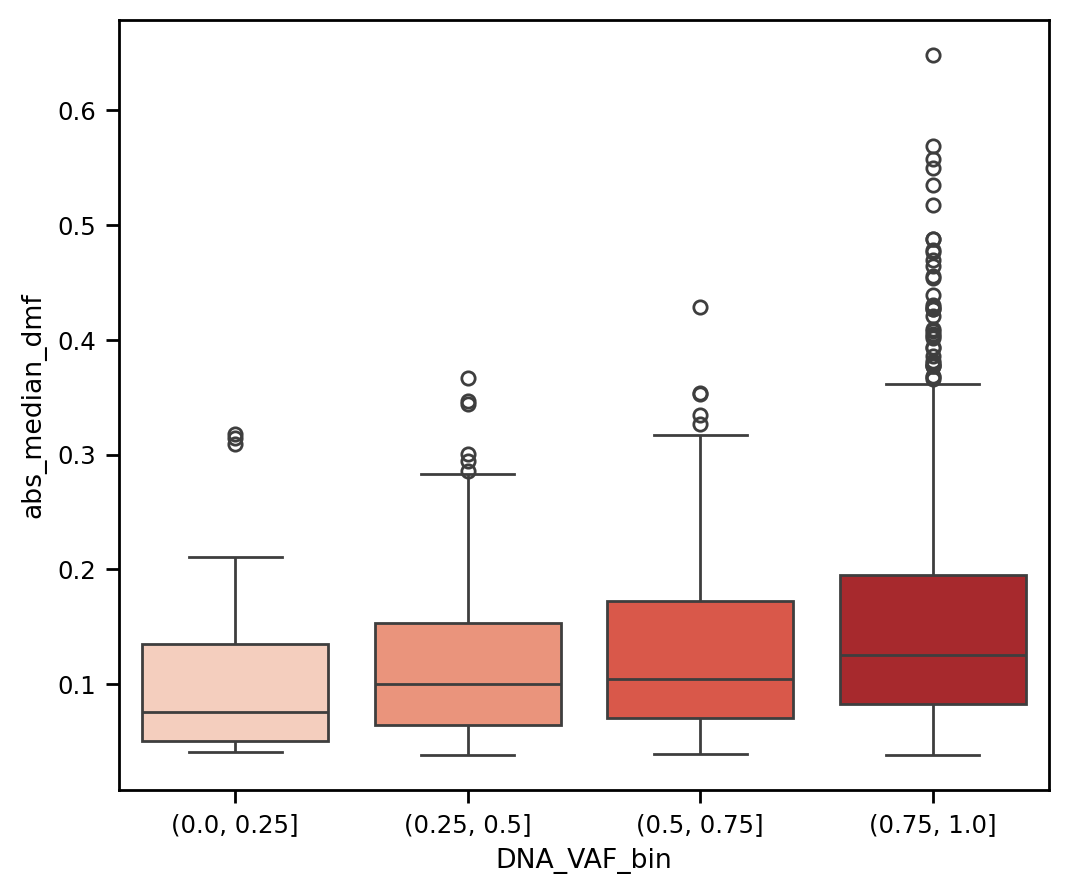

In [13]:
filtered_df = icgc_dist_mean_metrics_w_annot_all_vaf.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# get absolute value of median dmf
filtered_df['abs_median_dmf'] = filtered_df['median_dmf'].abs()
# bin by DNA VAF
filtered_df['DNA_VAF_bin'] = pd.cut(
    filtered_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )

fig, axes = plt.subplots(figsize = (6,5), dpi = 100)
sns.set_context('paper')

# boxplot
sns.boxplot(
    data=filtered_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=True, palette = 'Reds',
    ax = axes
    )

plt.savefig(os.path.join(fig_out_dir, 'figure4e.svg'), dpi = 300, format = 'svg')